In [1]:
from transformers import AutoTokenizer
import torch
import numpy as np
import functools
from sklearn import metrics
from torch.utils.data import DataLoader
import sys

sys.path.append('/home/skrhakv/cryptic-nn/src')
import baseline_utils
import finetuning_utils
from finetuning_utils import MultitaskFinetunedEsmModelWithCnn

MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [2]:
MODEL = 'multitask-finetuned-model-with-CNN-with-ligysis'
MODEL_PATH = f'/home/skrhakv/cryptic-nn/final-data/trained-models/{MODEL}.pt'

finetuned_model = torch.load(MODEL_PATH, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


In [33]:
distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances'
plDDT_path='/home/skrhakv/cryptic-nn/data/cryptobench/plDDT'

plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', plDDT_path=plDDT_path)
distances_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', distances_path=distances_path)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, plDDT_path=plDDT_path, plDDT_scaler=plDDT_scaler, distances_path=distances_path, distances_scaler=distances_scaler)
partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

In [4]:
finetuned_model.pLDDT_conv

Sequential(
  (0): Conv1d(1, 128, kernel_size=(15,), stride=(1,), padding=(7,))
  (1): ReLU()
  (2): Conv1d(128, 128, kernel_size=(15,), stride=(1,), padding=(7,))
  (3): ReLU()
  (4): Conv1d(128, 128, kernel_size=(15,), stride=(1,), padding=(7,))
  (5): ReLU()
)

In [8]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

with torch.no_grad():
    finetuned_model.eval()
    for batch in val_dataloader:
        finetuned_model.pLDDT_conv.register_forward_hook(get_activation('pLDDT_conv'))
        output, _, _ = finetuned_model(batch)
        print(activation['pLDDT_conv'])
        break

tensor([[[0.0000, 0.8145, 0.0000,  ..., 0.9482, 0.6226, 1.1348],
         [0.0000, 0.0000, 0.0770,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 5.5000, 2.9863,  ..., 0.0000, 1.2803, 0.6621],
         ...,
         [1.9492, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7524],
         [0.0000, 3.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 3.3320, 1.7666,  ..., 0.0000, 0.0000, 2.2344]],

        [[0.0000, 0.8188, 0.0000,  ..., 0.9482, 0.6226, 1.1348],
         [0.0000, 0.0000, 0.0800,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 5.5039, 2.9883,  ..., 0.0000, 1.2803, 0.6621],
         ...,
         [1.9453, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7524],
         [0.0000, 3.0371, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 3.3340, 1.7686,  ..., 0.0000, 0.0000, 2.2344]],

        [[0.0000, 0.8149, 0.0000,  ..., 0.9482, 0.6226, 1.1348],
         [0.0000, 0.0000, 0.0766,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 5.5000, 2.9883,  ..., 0.0000, 1.2803, 0.

In [ ]:
activation['pLDDT_conv'][41].reshape(-1, 128)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


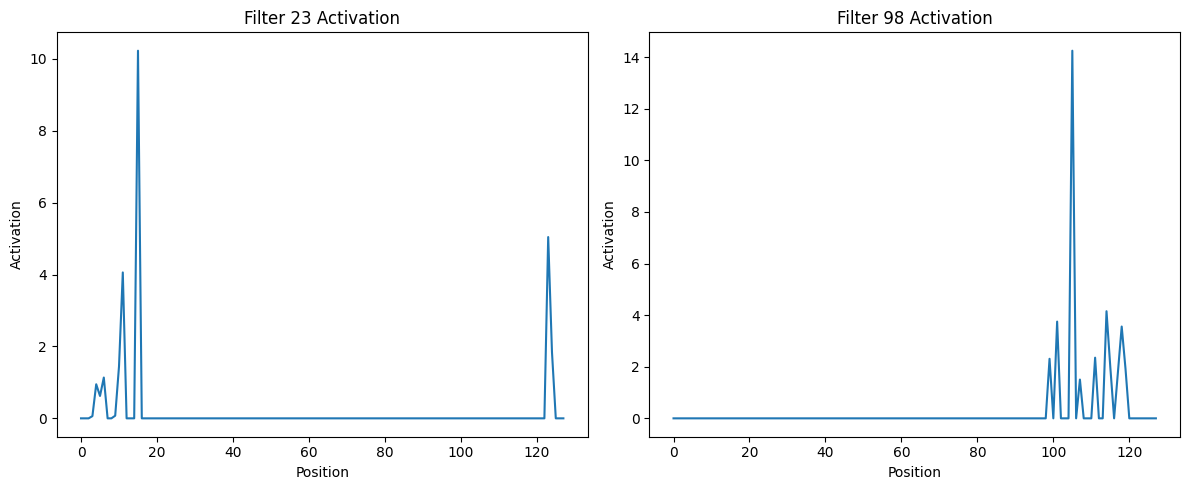

In [52]:
# shape: [184, 128, 903] -> 184 sequences, 128 channels, 903 positions
reshaped_activation = activation['pLDDT_conv'][41].reshape(-1, 128)
print(reshaped_activation[23].cpu().numpy())
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reshaped_activation[7].cpu().numpy())
plt.title('Filter 23 Activation')
plt.xlabel('Position')
plt.ylabel('Activation')

plt.subplot(1, 2, 2)
plt.plot(reshaped_activation[98].cpu().numpy())
plt.title('Filter 98 Activation')
plt.xlabel('Position')
plt.ylabel('Activation')

plt.tight_layout()
plt.show()

In [35]:
import os

APO_HOLO_DISTANCE_DIRECTORY = '/home/skrhakv/cryptic-nn/final-data/cryptobench/residue-distances'
apo_holo_distance = np.load(os.path.join(APO_HOLO_DISTANCE_DIRECTORY, '6btyB.npy'))
apo_holo_distance

array([9.74   , 9.734  , 8.37   , 5.45   , 1.138  , 0.4336 , 0.275  ,
       0.10815, 0.2069 , 0.362  , 0.3083 , 0.3186 , 0.5474 , 0.4492 ,
       0.2148 , 0.322  , 0.448  , 0.3655 , 0.3062 , 0.3584 , 0.4597 ,
       0.59   , 0.2698 , 0.3196 , 0.338  , 0.178  , 0.322  , 0.5938 ,
       0.5776 , 0.8037 , 0.4614 , 0.91   , 1.777  , 0.5186 , 1.281  ,
       1.098  , 0.387  , 0.3323 , 0.3596 , 0.295  , 0.325  , 0.646  ,
       0.343  , 0.176  , 0.1665 , 0.268  , 0.7407 , 2.223  , 6.246  ,
       7.504  , 4.305  , 2.215  , 0.545  , 0.3298 , 0.5205 , 0.5454 ,
       0.3076 , 0.4692 , 0.467  , 0.5234 , 0.769  , 1.041  , 0.4346 ,
       0.4182 , 0.3528 , 0.3728 , 0.3223 , 0.2084 , 0.4111 , 0.319  ,
       0.3003 , 0.276  , 0.3396 , 0.2886 , 0.7227 , 0.4937 , 0.7363 ,
       0.819  , 0.646  , 0.6514 , 0.731  , 0.4133 , 0.1763 , 0.288  ,
       0.3762 , 0.304  , 0.298  , 0.265  , 0.3083 , 0.2922 , 0.2489 ,
       0.3647 , 0.3696 , 0.5537 , 0.8423 , 1.563  , 3.79   , 5.027  ,
       2.115  , 0.82

In [ ]:
with open('/home/skrhakv/cryptic-nn/final-data/cryptobench/sequences/6btyB.txt', 'r') as f:
    sequence = f.read()
print(sequence[97:100])
apo_holo_distance[97:100]

# flexible R1653

REN


array([5.027 , 2.115 , 0.8223], dtype=float16)

In [45]:
print(sequence[50:57])
apo_holo_distance[50:57]

KTSKRKT


array([4.305 , 2.215 , 0.545 , 0.3298, 0.5205, 0.5454, 0.3076],
      dtype=float16)

In [ ]:
print(sequence[0:25])
apo_holo_distance[22:25]

## check for the 22th residue (V1578) - it should be in a relatively static region - 
## the apo-holo distance for all the residues in proximity (7 to left and 7 to right) is 
## lower than 1 A RMSD.

SNAIGGAVKLSISYRNGTLFIMVMH


array([0.2698, 0.3196, 0.338 ], dtype=float16)

In [ ]:
print(sequence[22:25])
apo_holo_distance[22:25]

## check for the 22th residue - it should be in a relatively static region - 
## the apo-holo distance for all the residues in proximity (7 to left and 7 to right) is 
## lower than 1 A RMSD.